In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

In [4]:
from util import show, plot_images, plot_tensors

In [5]:
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from skimage.measure import compare_psnr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()

])
train_data = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(
    root=GT_DATA_PATH, transform=TRANSFORM_IMG)

dataset1 = train_data
dataset2 = gt_data

In [6]:
class gtmatch():
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y = self.dataset2[int(index / batch_size % batch_size)][0]
        return x, y

    def __len__(self):
        return len(self.dataset1)


newdataset = gtmatch(dataset1, dataset2, 50)

In [7]:
from torch import randn
batch_size = 50


def add_noise(img):
    return img + randn(img.size())*0.1


class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

In [8]:
newdataset = SyntheticNoiseDataset(newdataset, 'train')

In [9]:
from models.RIM import RIM
from models.babyunet import BabyUnet

In [10]:
model = RIM()
model2 = BabyUnet()

In [11]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import logging
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [12]:
from torch.utils.data.sampler import SequentialSampler
validation_split = .2
random_seed = 42
shuffle_dataset = False

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)


train_loader = torch.utils.data.DataLoader(
    newdataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## RIM

In [16]:
data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_val_loss = 1

for i, batch in enumerate(data_loader):

    noisy_images, clean_images = batch

    model.train()

    net_input = noisy_images

    if i == 0:

        st = torch.zeros(net_input.size())

    net_output, st = model(net_input, st)

    loss = loss_function(net_output, noisy_images)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    losses.append(loss.item())
    model.eval()

    val_loss = loss_function(net_output, noisy_images)

    val_losses.append(val_loss.item())

    print("Loss (", i, "): \t", round(loss.item(), 4))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = noisy_images*model(noisy_images, st)[0].detach()
        net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
        denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        clean_comp = clean_images.detach().cpu().numpy()[
            0, 0].astype(np.float64)
        best_psnr = compare_psnr(clean_comp, denoised_arr)
        noisy_input.append(net_input_np)
        best_images.append(denoised_arr)
        clean_image_corr.append(clean_images)
        print("\tModel PSNR: ", np.round(best_psnr, 2))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss ( 0 ): 	 0.0575


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  28.35
Loss ( 1 ): 	 0.0559
	Model PSNR:  22.48
Loss ( 2 ): 	 0.0545
	Model PSNR:  21.86
Loss ( 3 ): 	 0.0534
	Model PSNR:  26.52
Loss ( 4 ): 	 0.0496
	Model PSNR:  22.9
Loss ( 5 ): 	 0.0499
Loss ( 6 ): 	 0.0485
	Model PSNR:  20.95
Loss ( 7 ): 	 0.0465
	Model PSNR:  22.71
Loss ( 8 ): 	 0.0485
Loss ( 9 ): 	 0.0464
	Model PSNR:  26.44
Loss ( 10 ): 	 0.0446
	Model PSNR:  20.94
Loss ( 11 ): 	 0.0439
	Model PSNR:  24.55
Loss ( 12 ): 	 0.0426
	Model PSNR:  22.62
Loss ( 13 ): 	 0.0396
	Model PSNR:  20.64
Loss ( 14 ): 	 0.0397
Loss ( 15 ): 	 0.0391
	Model PSNR:  21.16


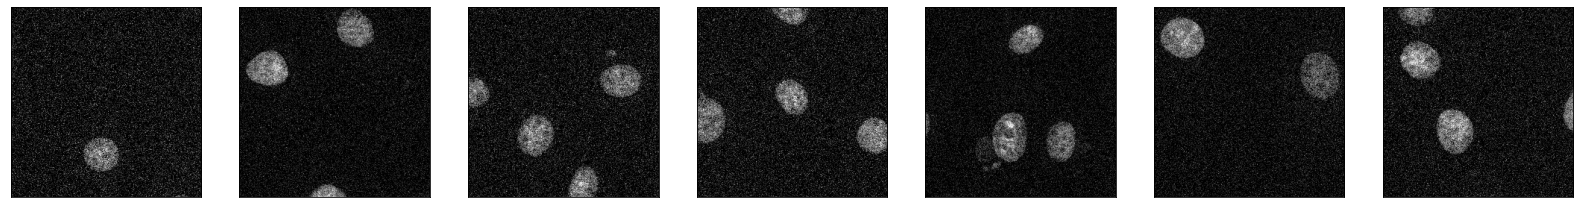

In [17]:
plot_images(best_images[::2])

In [22]:
model_output = []
Input_PSNR = []
Model_PSNR = []

model_output = []
Input_PSNR = []
Model_PSNR = []
Model_loss = []
clipped_model_loss = []


for i, batch in enumerate(validation_loader):

    noisy_images, clean_images = batch

    model.eval()

    net_input = noisy_images

    denoised = noisy_images*model(noisy_images, st)[0].detach()
    denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    model_output.append([torch.from_numpy(net_input_np), torch.from_numpy(denoised_arr),torch.from_numpy(clean_comp)])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    
    Model_loss.append(loss_function(denoised, noisy_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), noisy_images))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.m

Input PSNR =  20.01
Simple RIM PSNR =  28.0593

Simple RIM Loss =  tensor(0.0127)
Clipped Simple RIM Loss =  tensor(0.0164, dtype=torch.float64)


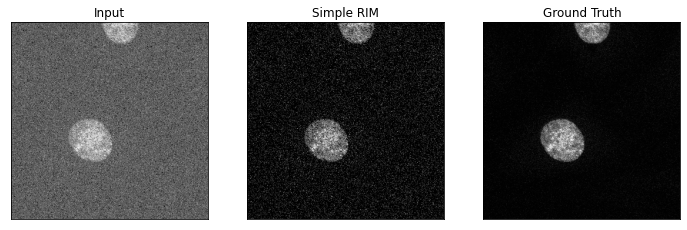

In [23]:
idx=1
plot_tensors(model_output[idx], ["Input", "Simple RIM","Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))

In [24]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))

Average Input PSNR =  20.01
Average Simple RIM PSNR =  24.4958

Average Simple RIM Loss =  0.0106
Average Clipped Simple RIM Loss =  0.0143


## RIM with J-Invariant Mask

In [14]:
from mask_RIM import Masker
masker = Masker(width=4, mode='interpolate')

data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_Jimages = []
best_val_loss = 1


for i, batch in enumerate(data_loader):
    noisy_images, clean_images = batch

    model.train()

    net_input, mask = masker.mask(noisy_images, i % (masker.n_masks - 1))

    if i == 0:
        st = torch.zeros(net_input.size())

    net_output, st = model(net_input, st)

    loss = loss_function(net_output*mask, noisy_images*mask)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    losses.append(loss.item())

    model.eval()
    val_loss = loss_function(net_output*mask, noisy_images*mask)
    val_losses.append(val_loss.item())

    print("Loss (", i, "): \t", round(loss.item(), 4))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = noisy_images*model(noisy_images, st)[0].detach()
        Jinv = noisy_images * \
            masker.infer_full_image(noisy_images, model, st)[0].detach()
        Jinv = np.clip(Jinv, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
        denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        clean_comp = clean_images.detach().cpu().numpy()[
            0, 0].astype(np.float64)

        best_psnr = compare_psnr(clean_comp, Jinv)

        noisy_input.append(net_input_np)
        best_images.append(denoised_arr)
        best_Jimages.append(Jinv)
        clean_image_corr.append(clean_images)
        print("\tModel PSNR: ", np.round(best_psnr, 2))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss ( 0 ): 	 0.001


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  27.25
Loss ( 1 ): 	 0.0013
Loss ( 2 ): 	 0.0013
Loss ( 3 ): 	 0.001
	Model PSNR:  25.35
Loss ( 4 ): 	 0.0012
Loss ( 5 ): 	 0.0012
Loss ( 6 ): 	 0.0013
Loss ( 7 ): 	 0.0012
Loss ( 8 ): 	 0.0011
Loss ( 9 ): 	 0.0009
	Model PSNR:  25.22
Loss ( 10 ): 	 0.0012
Loss ( 11 ): 	 0.001
Loss ( 12 ): 	 0.0011
Loss ( 13 ): 	 0.0011
Loss ( 14 ): 	 0.0013
Loss ( 15 ): 	 0.0011


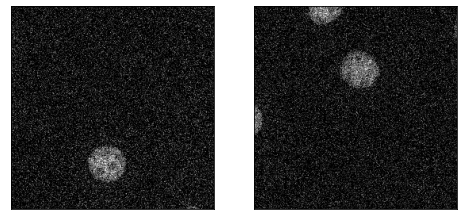

In [15]:
plot_images(best_images[::2])

In [23]:
model_output = []
Input_PSNR = []
Model_PSNR = []
JInv_PSNR = []
Model_loss = []
clipped_model_loss = []

JInv_loss = []
clipped_JInv_loss = []

for i, batch in enumerate(validation_loader):

    noisy_images, clean_images = batch

    model.eval()

    net_input = noisy_images

    denoised = noisy_images*model(noisy_images, st)[0].detach()
    denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)
    Jinv = noisy_images * \
        masker.infer_full_image(noisy_images, model, st)[0].detach()
    Jinv_np = np.clip(Jinv, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)

    model_output.append([torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), torch.from_numpy(Jinv_np), torch.from_numpy(clean_comp)])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    JInv_PSNR.append(compare_psnr(clean_comp, Jinv_np))
    
    Model_loss.append(loss_function(denoised, noisy_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), noisy_images))
    
    JInv_loss.append(loss_function(Jinv, noisy_images))
    clipped_JInv_loss.append(loss_function(
        torch.from_numpy(Jinv_np), noisy_images))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/w

Input PSNR =  20.01
Simple RIM PSNR =  20.8064
J-Invariant RIM PSNR =  20.8064

Simple RIM Loss =  tensor(0.0173)
Clipped Simple RIM Loss =  tensor(0.0185, dtype=torch.float64)

J-Invariant RIM Loss =  tensor(0.0173)
Clipped J-Invariant RIM Loss =  tensor(0.0185, dtype=torch.float64)


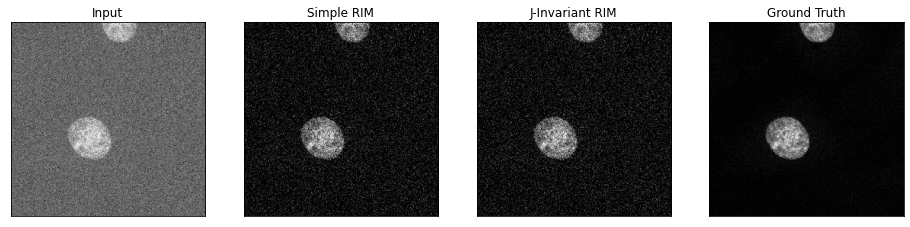

In [29]:
idx=1
plot_tensors(model_output[idx], ["Input", "Simple RIM",
                               "J-Invariant RIM", "Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("J-Invariant RIM PSNR = ", np.round(JInv_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))
print("")
print("J-Invariant RIM Loss = ", np.round(JInv_loss[idx], 4))
print("Clipped J-Invariant RIM Loss = ", np.round(clipped_JInv_loss[idx], 4))

In [30]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("Average J-Invariant RIM PSNR = ", np.round(np.mean(JInv_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))
print("")
print("Average J-Invariant RIM Loss = ", np.round(np.mean(JInv_loss), 4))
print("Average Clipped J-Invariant RIM Loss = ", np.round(np.mean(clipped_JInv_loss), 4))

Average Input PSNR =  20.0
Average Simple RIM PSNR =  23.2391
Average J-Invariant RIM PSNR =  23.2391

Average Simple RIM Loss =  0.0145
Average Clipped Simple RIM Loss =  0.0157

Average J-Invariant RIM Loss =  0.0145
Average Clipped J-Invariant RIM Loss =  0.0157


## BABY UNET COMPARISON

In [13]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

data_loader = train_loader

#noisy, clean = noisy_data_train[0];
#net_input, mask = masker.mask(noisy.unsqueeze(0), 0);

losses = []
val_losses = []
best_images = []
best_val_loss = 1



for i, batch in enumerate(data_loader):

    noisy_images, clean_images = batch
    
    model2.train()
 
    net_input, mask = masker.mask(noisy_images, i)
    #net_input = noisy_images
    
    net_output = model2(net_input)

        
    loss = loss_function(net_output*mask, noisy_images*mask)
    #loss = loss_function(net_output, noisy_images)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()

    losses.append(loss.item())
    model2.eval()
    

    val_loss = loss_function(net_output*mask, noisy_images*mask)
    #val_loss = net_output

    val_losses.append(val_loss.item())



    print("Loss (", i, "): \t", round(loss.item(), 4))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = np.clip(model2(noisy_images).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        clean=np.clip(clean_images.detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        best_psnr = compare_psnr(clean,denoised)
        best_images.append(denoised)
        print("\tModel PSNR: ", np.round(best_psnr, 2))


Loss ( 0 ): 	 0.1112


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  26.23
Loss ( 1 ): 	 0.1154
Loss ( 2 ): 	 0.1136
Loss ( 3 ): 	 0.1119
Loss ( 4 ): 	 0.1143
Loss ( 5 ): 	 0.1158
Loss ( 6 ): 	 0.1149
Loss ( 7 ): 	 0.1145
Loss ( 8 ): 	 0.1184
Loss ( 9 ): 	 0.1144
Loss ( 10 ): 	 0.1178
Loss ( 11 ): 	 0.1158
Loss ( 12 ): 	 0.1154
Loss ( 13 ): 	 0.1153
Loss ( 14 ): 	 0.1124
Loss ( 15 ): 	 0.1169


TypeError: 'AxesSubplot' object does not support indexing

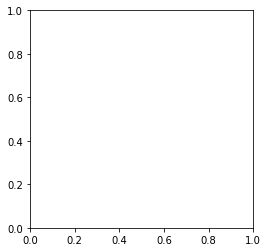

In [15]:
plot_images(best_images)

In [1]:
model_output = []
Input_PSNR = []
Model_PSNR = []
JInv_PSNR = []
Model_loss = []
clipped_model_loss = []

JInv_loss = []
clipped_JInv_loss = []

for i, batch in enumerate(validation_loader):

    noisy_images, clean_images = batch

    model2.eval()

    net_input = noisy_images

    denoised = noisy_images*model2(noisy_images)[0].detach()
    denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)
    Jinv = noisy_images * \
        masker.infer_full_image(noisy_images, model2)[0].detach()
    Jinv_np = np.clip(Jinv, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)

    model_output.append([torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), torch.from_numpy(Jinv_np), torch.from_numpy(clean_comp)])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    JInv_PSNR.append(compare_psnr(clean_comp, Jinv_np))
    
    Model_loss.append(loss_function(denoised, noisy_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), noisy_images))
    
    JInv_loss.append(loss_function(Jinv, noisy_images))
    clipped_JInv_loss.append(loss_function(
        torch.from_numpy(Jinv_np), noisy_images))

NameError: name 'validation_loader' is not defined

In [ ]:
idx=1
plot_tensors(model_output[idx], ["Input", "Simple RIM",
                               "J-Invariant RIM", "Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("J-Invariant RIM PSNR = ", np.round(JInv_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))
print("")
print("J-Invariant RIM Loss = ", np.round(JInv_loss[idx], 4))
print("Clipped J-Invariant RIM Loss = ", np.round(clipped_JInv_loss[idx], 4))

In [ ]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("Average J-Invariant RIM PSNR = ", np.round(np.mean(JInv_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))
print("")
print("Average J-Invariant RIM Loss = ", np.round(np.mean(JInv_loss), 4))
print("Average Clipped J-Invariant RIM Loss = ", np.round(np.mean(clipped_JInv_loss), 4))